In [40]:
import pandas as pd
import re
from word2number import w2n
import re
from xml.dom import minidom
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from openpyxl import load_workbook
from openpyxl.chart import BarChart, Reference

# Data obtention

In [41]:
# This function reads the data and returns pandas dataframes
def extract():
    pizzas = pd.read_csv('ORIGINALS/pizzas.csv')
    pizza_types = pd.read_csv('ORIGINALS/pizza_types.csv', encoding='latin-1')
    orders = pd.read_csv('ORIGINALS/orders_2016.csv', sep=';')
    order_details = pd.read_csv('ORIGINALS/order_details_2016.csv', sep=';', encoding='latin-1')
    data_dictionary = pd.read_csv('ORIGINALS/data_dictionary.csv')
    return pizzas, pizza_types, orders, order_details, data_dictionary


# Data analysis

In [42]:
data = extract()
df_name = ['pizzas', 'pizza_types', 'orders', 'order_details', 'data_dictionary']
for idx, df in enumerate(data):
    print('\nDataframe:', df_name[idx])
    display(df.head())
    print('\nColumn dtypes:')
    print(df.dtypes)
    print('\nNumber of null values:')
    print(df.isnull().sum())



Dataframe: pizzas


,pizza_id,pizza_type_id,size,price
0,bbq_ckn_s,bbq_ckn,S,12.75
1,bbq_ckn_m,bbq_ckn,M,16.75
2,bbq_ckn_l,bbq_ckn,L,20.75
3,cali_ckn_s,cali_ckn,S,12.75
4,cali_ckn_m,cali_ckn,M,16.75



Column dtypes:
pizza_id          object
pizza_type_id     object
size              object
price            float64
dtype: object

Number of null values:
pizza_id         0
pizza_type_id    0
size             0
price            0
dtype: int64

Dataframe: pizza_types


,pizza_type_id,name,category,ingredients
0,bbq_ckn,The Barbecue Chicken Pizza,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,..."
1,cali_ckn,The California Chicken Pizza,Chicken,"Chicken, Artichoke, Spinach, Garlic, Jalapeno ..."
2,ckn_alfredo,The Chicken Alfredo Pizza,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A..."
3,ckn_pesto,The Chicken Pesto Pizza,Chicken,"Chicken, Tomatoes, Red Peppers, Spinach, Garli..."
4,southw_ckn,The Southwest Chicken Pizza,Chicken,"Chicken, Tomatoes, Red Peppers, Red Onions, Ja..."



Column dtypes:
pizza_type_id    object
name             object
category         object
ingredients      object
dtype: object

Number of null values:
pizza_type_id    0
name             0
category         0
ingredients      0
dtype: int64

Dataframe: orders


,order_id,date,time
0,8886,May 29 2016,18:58 PM
1,11424,2016-07-10,14:36:32
2,19361,"Saturday,26 November, 2016",18:42 PM
3,4489,2016-03-17,NaN
4,6838,NaN,15:09:12



Column dtypes:
order_id     int64
date        object
time        object
dtype: object

Number of null values:
order_id       0
date        2353
time        2038
dtype: int64

Dataframe: order_details


,order_details_id,order_id,pizza_id,quantity
0,21671,9513,cali-ckn-m,NaN
1,17259,7591,green garden s,1
2,19844,8724,the-greek-xl,1
3,24185,10625,NaN,1
4,13779,6037,thai_ckn_m,1



Column dtypes:
order_details_id     int64
order_id             int64
pizza_id            object
quantity            object
dtype: object

Number of null values:
order_details_id       0
order_id               0
pizza_id            5673
quantity            4726
dtype: int64

Dataframe: data_dictionary


,Table,Field,Description
0,orders,order_id,Unique identifier for each order placed by a t...
1,orders,date,Date the order was placed (entered into the sy...
2,orders,time,Time the order was placed (entered into the sy...
3,order_details,order_details_id,Unique identifier for each pizza placed within...
4,order_details,order_id,Foreign key that ties the details in each orde...



Column dtypes:
Table          object
Field          object
Description    object
dtype: object

Number of null values:
Table          0
Field          0
Description    0
dtype: int64


In [43]:
def anomalies(order_details, pizzas):
    anomaly = False
    for pizza in order_details['pizza_id']:
        if pizza not in pizzas['pizza_id'].unique():
            print(f'Pizza ID "{pizza}" not recognized')
            anomaly = True
    if not anomaly:
        print('No anomalies found')

anomalies(data[3], data[0])

Pizza ID "cali-ckn-m" not recognized
Pizza ID "green garden s" not recognized
Pizza ID "the-greek-xl" not recognized
Pizza ID "nan" not recognized
Pizza ID "thai-ckn-m" not recognized
Pizza ID "the-greek-m" not recognized
Pizza ID "cl@ssic_dlx_m" not recognized
Pizza ID "napolitana l" not recognized
Pizza ID "sicilian-m" not recognized
Pizza ID "nan" not recognized
Pizza ID "big-meat-s" not recognized
Pizza ID "ckn_alfred0_m" not recognized
Pizza ID "nan" not recognized
Pizza ID "nan" not recognized
Pizza ID "bbq-ckn-l" not recognized
Pizza ID "cali ckn m" not recognized
Pizza ID "nan" not recognized
Pizza ID "it@l_cpcllo_l" not recognized
Pizza ID "nan" not recognized
Pizza ID "cl@ssic_dlx_m" not recognized
Pizza ID "ital_cpcll0_l" not recognized
Pizza ID "nan" not recognized
Pizza ID "spin@ch_fet_l" not recognized
Pizza ID "nan" not recognized
Pizza ID "nan" not recognized
Pizza ID "spin-pesto-l" not recognized
Pizza ID "spinach-fet-m" not recognized
Pizza ID "pepperoni m" not recogn

# Data transformation

In [44]:
# In this cell we will clean up the data and get rid of null values and transform the data to the correct format

# First, we will get rid of the null values in the orders and order_details dataframe
def clean_data(ordered_pizzas):
    ordered_pizzas.pop('time')
    ordered_pizzas.pop('order_details_id')
    ordered_pizzas = ordered_pizzas.dropna()
    ordered_pizzas = ordered_pizzas[ordered_pizzas['pizza_id'] != 'nan']
    ordered_pizzas = ordered_pizzas.reset_index(drop=True)
    return ordered_pizzas

# Then we will transform the data to the correct format
def transform_data(orders, order_details):
    ordered_pizzas = pd.merge(orders, order_details, on='order_id')
    ordered_pizzas['date'] = [control_date(x) for x in ordered_pizzas['date']]
    # We will use regex to write pizza_id with the correct format (e.g. pizza_flv_size)
    ordered_pizzas['pizza_id'] = [re.sub('[ -]', '_', str(x)) for x in ordered_pizzas['pizza_id']]
    # There are some values that are misswritten in the pizza_id column, so we will correct them
    ordered_pizzas['pizza_id'] = [re.sub('@', 'a', str(x)) for x in ordered_pizzas['pizza_id']]
    ordered_pizzas['pizza_id'] = [re.sub('3', 'e', str(x)) for x in ordered_pizzas['pizza_id']]
    ordered_pizzas['pizza_id'] = [re.sub('0', 'o', str(x)) for x in ordered_pizzas['pizza_id']]
    # We will use the word2number library to transform the string number to integer
    ordered_pizzas['quantity'] = [control_w2n(x) for x in ordered_pizzas['quantity']]
    ordered_pizzas = clean_data(ordered_pizzas)
    return ordered_pizzas.astype({'quantity': 'int64'})


def control_w2n(x):
    try:
        return w2n.word_to_num(str(x))
    except:
        return

def control_date(x):
    try:
        if re.findall('\A\d\d-\d\d-\d\d', x):
            return pd.to_datetime(x, format='%d-%m-%y %H:%M:%S')
        else:
            return pd.to_datetime(float(x)+3600, unit='s')
    except:
        return pd.to_datetime(x)

In [45]:
# In this cell we create transformed csv files from the original ones

# We create a csv with the pizzas ordered in each order, instead of having each pizza in a different row
def csv_orders(ordered_pizzas):
    pizza_order = {}
    for i in ordered_pizzas['order_id']:
        if i not in pizza_order:
            pizza_order[i] = []
    for i in range(len(ordered_pizzas)):
        for _ in range(ordered_pizzas['quantity'][i]):
            pizza_order[ordered_pizzas['order_id'][i]].append(ordered_pizzas['pizza_id'][i])
    ordered_pizzas['pizzas'] = [pizza_order[x] for x in ordered_pizzas['order_id']]
    ordered_pizzas.pop('quantity')
    ordered_pizzas.pop('pizza_id')
    ordered_pizzas = (ordered_pizzas.drop_duplicates(subset=['order_id'])).reset_index(drop=True)
    ordered_pizzas.to_csv('TRANSFORMED/ordered_pizzas_2016.csv', index=False)
    return ordered_pizzas

# This function adds to the ordered_pizzas dataframe the day of the week of each order
def csv_with_days(ordered_pizzas):
    dates = []
    days = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
    for date in ordered_pizzas['date']:
        dates.append(days[date.weekday()])
    ordered_pizzas['day'] = dates
    ordered_pizzas.to_csv('TRANSFORMED/ordered_pizzas_2016.csv', index=False)
    return ordered_pizzas

# This function creates a csv with all the ingredients and the amount of each one for each day of the week (and total week)
def csv_ingredients(pizza_types):
    all_ingredients = []
    for ingredients in pizza_types['ingredients']:
        for ingredient in ingredients.split(', '):
            ingredient = re.sub('ï¿½','', ingredient)
            if ingredient not in all_ingredients:
                all_ingredients.append(ingredient)
    ingredients_df = pd.DataFrame({'ingredient': all_ingredients, 'Monday': [0 for _ in range(len(all_ingredients))], 'Tuesday': [0 for i in range(len(all_ingredients))], 'Wednesday': [0 for i in range(len(all_ingredients))], 'Thursday': [0 for i in range(len(all_ingredients))], 'Friday': [0 for i in range(len(all_ingredients))], 'Saturday': [0 for i in range(len(all_ingredients))], 'Sunday': [0 for i in range(len(all_ingredients))], 'Total': [0 for i in range(len(all_ingredients))]})
    ingredients_df.to_csv('TRANSFORMED/ingredients_2016.csv', index=False)
    return ingredients_df


In [46]:
# We create a function that returns the pizza flavour and size of a pizza
def search_pizza(pizza_id, pizzas):
    pizza = pizzas[pizzas['pizza_id'] == pizza_id]
    return pizza['pizza_type_id'].values[0], pizza['size'].values[0]

# This function adds to the pizzas csv the amount of pizzas ordered each day of the week
# We calculate this by pizza, where we use the size as a factor 
def create_csv_with_pizzas_per_day(ordered_pizzas, pizza_types, pizzas_data, date):
    lst = [0 for _ in range(len(pizza_types))]
    weigths = {'S': 1, 'M': 1.5, 'L': 2, 'XL': 2.5, 'XXL': 3}
    pizza_counts = {'Monday': lst.copy(), 'Tuesday': lst.copy(), 'Wednesday': lst.copy(), 'Thursday': lst.copy(), 'Friday': lst.copy(), 'Saturday': lst.copy(), 'Sunday': lst.copy()}
    for _, order in ordered_pizzas.iterrows():
        if pd.to_datetime(order['date']) >= date:
            break
        else:
            day = order['day']
            pizzas = order['pizzas']
            for pizza in pizzas:
                pizza_flavour, size = search_pizza(pizza, pizzas_data)
                ind = pizza_types[pizza_types['pizza_type_id'] == pizza_flavour].index.values[0]
                pizza_counts[day][ind] += 1*weigths[size]
    for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']:
        pizza_types[day] = pizza_counts[day]
    pizza_types.to_csv('TRANSFORMED/pizza_counts_2016.csv', index=False)
    return pizza_types

# This function calculates the amount of ingredients needed a specific day of the week
def ingredients_quantity(day, pizza_types, pizza_type_id, days_difference):
    aux = (pizza_types[pizza_types['pizza_type_id'] == pizza_type_id][day].values[0])
    return aux*7/days_difference

# This function predicts the ingredients needed for the following week
def predict(pizza_types, ingredients_df, days_difference):
    for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']:
        for ingredients in pizza_types['ingredients']:
            pizza_type_id = pizza_types[pizza_types['ingredients'] == ingredients]['pizza_type_id'].values[0]
            for ingredient in ingredients.split(', '): 
                ingredient = re.sub('ï¿½','', ingredient)
                ind = ingredients_df[ingredients_df['ingredient'] == ingredient].index.values[0]   
                prediction = ingredients_quantity(day, pizza_types, pizza_type_id, days_difference)
                ingredients_df.loc[ind,[day]] += prediction
                ingredients_df.loc[ind,['Total']] += prediction
    ingredients_df.to_csv('TRANSFORMED/ingredients_2016.csv', index=False)
    return ingredients_df

# def check_ingredients(ingredients_df, pizza_types, orders, date, days_difference, pizzas_data):
#     weigths = {'S': 1, 'M': 1.5, 'L': 2, 'XL': 2.5, 'XXL': 3}
#     days = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
#     for _, order in orders.iterrows():
#         n = (pd.to_datetime(order['date'], format='%d/%m/%Y') - date).days
#         if n < 7 and n >= 0:
#             day = days[pd.to_datetime(order['date'], format='%d/%m/%Y').weekday()]
#             pizzas = order['pizzas']
#             for pizza in pizzas:
#                 pizza_flavour, size = search_pizza(pizza, pizzas_data)
#                 ingredients = pizza_types[pizza_types['pizza_type_id'] == pizza_flavour]['ingredients'].values[0]
#                 for ingredient in ingredients.split(', '): 
#                     ind = ingredients_df[ingredients_df['ingredient'] == ingredient].index.values[0]   
#                     ingredients_df.loc[ind,[day]] -= 1*weigths[size]
#                     ingredients_df.loc[ind,['Total']] -= 1*weigths[size]
#     return ingredients_df


In [47]:
date = pd.to_datetime('2016-12-31', format='%Y-%m-%d')
days_difference = (date - pd.to_datetime('2016-01-01', format='%Y-%m-%d')).days
pizzas, pizza_types, orders, order_details, data_dictionary = extract()
ordered_pizzas = transform_data(orders, order_details)
ordered_pizzas = csv_orders(ordered_pizzas)
ordered_pizzas = csv_with_days(ordered_pizzas)
ordered_pizzas = ordered_pizzas.sort_values(by=['date'])
display(ordered_pizzas)

,order_id,date,pizzas,day
2834,15,2016-01-01 00:00:00,"[soppressata_l, the_greek_s]",Friday
16466,38,2016-01-01 00:00:00,"[ital_cpcllo_l, hawaiian_s]",Friday
3225,46,2016-01-01 00:00:00,"[thai_ckn_m, classic_dlx_l, ckn_pesto_l]",Friday
3183,54,2016-01-01 00:00:00,"[thai_ckn_l, prsc_argla_m]",Friday
4345,49,2016-01-01 00:00:00,[sicilian_l],Friday
...,...,...,...,...
12668,21315,2016-12-31 17:47:46,"[peppr_salami_s, sicilian_l]",Saturday
14515,21318,2016-12-31 18:07:03,"[pepperoni_s, pep_msh_pep_m, bbq_ckn_m]",Saturday
4475,21319,2016-12-31 18:07:19,"[prsc_argla_m, veggie_veg_s]",Saturday
2533,21321,2016-12-31 18:18:30,[bbq_ckn_l],Saturday


In [48]:
pizza_types = create_csv_with_pizzas_per_day(ordered_pizzas, pizza_types, pizzas, date)
ingredients_df = csv_ingredients(pizza_types)
ingredients_df = predict(pizza_types, ingredients_df, days_difference)
ingredients_df = ingredients_df.astype({'Monday': 'int', 'Tuesday': 'int', 'Wednesday': 'int', 'Thursday': 'int', 'Friday': 'int', 'Saturday': 'int', 'Sunday': 'int', 'Total': 'int'})
print('This are the ingredients that you need to buy for the week:')
display(ingredients_df)

This are the ingredients that you need to buy for the week:


,ingredient,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Total
0,Barbecued Chicken,7,5,8,6,7,8,8,51
1,Red Peppers,49,42,47,45,50,51,57,343
2,Green Peppers,15,12,15,14,14,16,17,107
3,Tomatoes,81,68,79,77,82,85,93,568
4,Red Onions,59,48,59,56,59,62,66,411
...,...,...,...,...,...,...,...,...,...
60,Parmigiano Reggiano Cheese,5,5,5,7,7,7,7,45
61,Eggplant,2,2,2,2,3,2,3,18
62,Zucchini,6,6,6,6,7,7,8,48
63,Sun-dried Tomatoes,5,4,5,5,5,5,5,37


# Data report recommendation

In [49]:
def prettify(elem):
    """Return a pretty-printed XML string for the Element.
    """
    rough_string = ET.tostring(elem, 'utf-8')
    reparsed = minidom.parseString(rough_string, 'utf-8')
    return reparsed.toprettyxml(indent="    ")


In [50]:
%run quality_report_2016.ipynb
data = {}
data['prediction_per_ingredient'] = {}
for i in range(len(ingredients_df)):
    data['prediction_per_ingredient'][re.sub(' ', '_', (ingredients_df['ingredient'][i]))] = ingredients_df['Total'][i]


In [51]:
root = ET.Element('prediction')
sub = ET.SubElement(root, 'prediction_per_ingredient')
for key, value in data['prediction_per_ingredient'].items():
    ET.SubElement(sub, key).text = str(value)

with open('data_report_2016.xml', 'a') as f:
    f.write(prettify(root))

# Images generation

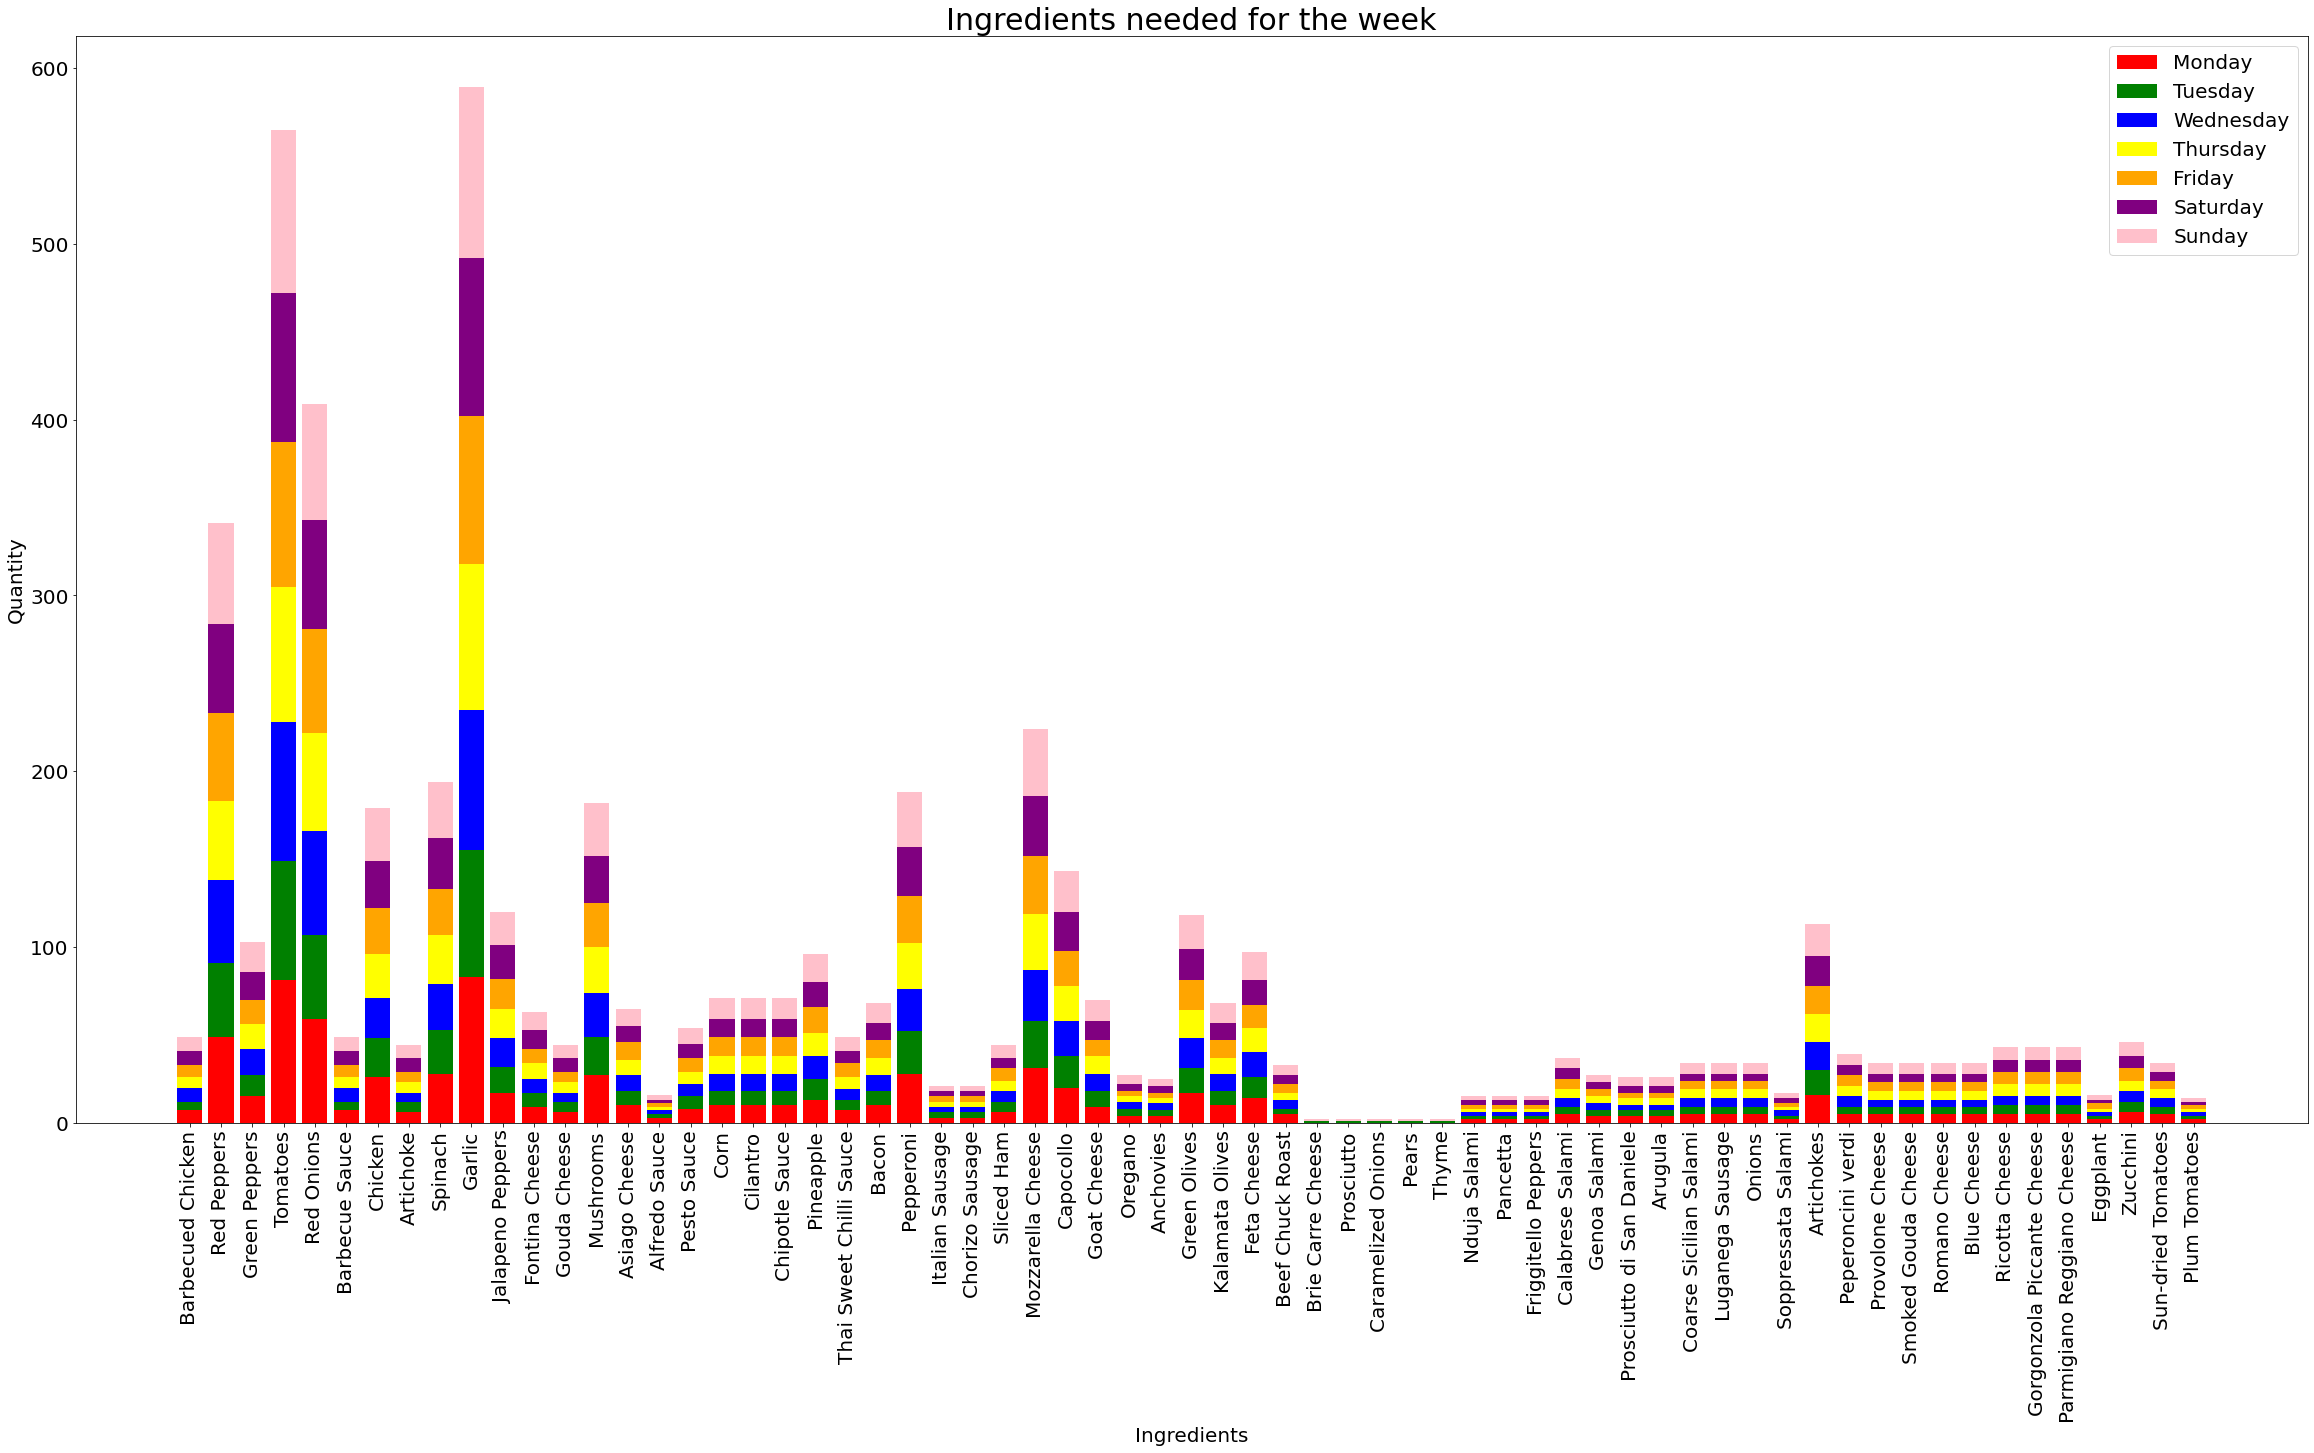

In [52]:
# Stacked bar chart
ings_df = ingredients_df.copy()
plt.figure(figsize=(40,20))
colors = ['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'pink']
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
bot = None
for i, day in enumerate(days):
    plt.bar(ings_df['ingredient'], ings_df[day], bottom=bot, color=colors[i])
    if bot is None:
        bot = ings_df[day]
    else:
        bot += ings_df[day]
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.title('Ingredients needed for the week', fontsize=30)
plt.xlabel('Ingredients', fontsize=20)
plt.ylabel('Quantity', fontsize=20)
plt.legend(days, fontsize=20)
plt.savefig('IMAGES/ingredients_2016.png', bbox_inches='tight', transparent=False)
plt.show()


# Excel report

In [53]:
ingredients_df.to_excel('data_report_2016.xlsx', startrow=2, startcol=2, sheet_name='Report', index=False)
wb = load_workbook('data_report_2016.xlsx')
ws = wb['Report']
col_0, col_1 = wb.active.min_column, wb.active.max_column - 1
row_0, row_1 = wb.active.min_row, wb.active.max_row
# Create a stacked bar chart
bcht = BarChart()
data = Reference(ws, min_col=col_0+1, min_row=row_0, max_col=col_1, max_row=row_1)
cats = Reference(ws, min_col=col_0, min_row=row_0+1, max_col=col_0, max_row=row_1)
bcht.grouping = 'stacked'
bcht.overlap = 100
bcht.add_data(data, titles_from_data=True)
bcht.set_categories(cats)
bcht.title = 'Ingredients needed for the week'
bcht.style = 2
bcht.y_axis.title = 'Quantity'
bcht.x_axis.title = 'Ingredients'
bcht.width = 40
bcht.height = 20
ws.add_chart(bcht, "N3")

wb.save('data_report_2016.xlsx')